# Predictive Modelling: LightGBM

# Imports

In [4]:
%load_ext autoreload
%autoreload 2

# Pandas and numpy
import pandas as pd
import numpy as np

# 
from IPython.display import display, clear_output
import sys
import time

# Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.visualize import plot_corr_matrix, plot_multi, plot_norm_dist, plot_feature_importances

# Some custom tools
from src.data.tools import check_for_missing_vals

# 
from src.models.predict_model import avg_model, run_combinations
#from src.models.train_model import run_combinations 

# Alpaca API
import alpaca_trade_api as tradeapi

# Pickle
import pickle
import os
from pathlib import Path

# To load variables from .env file into system environment
from dotenv import find_dotenv, load_dotenv

from atomm.Indicators import MomentumIndicators
from atomm.DataManager.main import MSDataManager
from atomm.Tools import calc_open_position, calc_returns
from src.visualization.visualize import plot_confusion_matrix
from atomm.Methods import BlockingTimeSeriesSplit, PurgedKFold           


import time

# scikit-learn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from xgboost import XGBClassifier

#from sklearn.ensemble import BaggingClassifier
#from sklearn.multiclass import OneVsRestClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# For BayesianHyperparameter Optimization
from atomm.Models.Tuning import search_space#, BayesianSearch
from hyperopt import space_eval

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.gridspec as gridspec
#import matplotlib.style as style
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
##### Load environment variables
load_dotenv(find_dotenv())

True

In [83]:
R_STATE = 16818

## Loading the data

In [9]:
data_base_dir = os.environ.get('DATA_DIR_BASE_PATH')


In [10]:
fname = os.path.join(data_base_dir, 'processed', 'index.h5')
fname = Path(fname)
#fname = '../data/processed/index.h5'

In [11]:
# Load dataset from HDF storage
with pd.HDFStore(fname) as storage:
    djia = storage.get('nyse/cleaned/rand_symbols')
    y_2c = storage.get('nyse/engineered/target_two_class')
    y_3c = storage.get('nyse/engineered/target_three_class')
    df_moments = storage.get('nyse/engineered/features')
    #print(storage.info())
    
# Create copies of the pristine data
X = df_moments.copy()
y = y_3c.copy()
y2 = y_2c.copy()
prices = djia.copy()

In [12]:
forecast_horizon = [1, 3, 5, 7, 10, 15, 20, 25, 30]
input_window_size = [3, 5, 7, 10, 15, 20, 25, 30]
ti_list = ['macd', 'rsi', 'stoc', 'roc', 'bbu', 'bbl', 'ema', 'atr', 'adx', 'cci', 'williamsr', 'stocd']
symbol_list = df_moments.columns.get_level_values(0).unique()

In [13]:
df_moments.columns.get_level_values(1).unique()

Index(['macd_3', 'rsi_3', 'stoc_3', 'roc_3', 'bbu_3', 'bbl_3', 'ema_3',
       'atr_3', 'adx_3', 'cci_3', 'williamsr_3', 'stocd_3', 'macd_5', 'rsi_5',
       'stoc_5', 'roc_5', 'bbu_5', 'bbl_5', 'ema_5', 'atr_5', 'adx_5', 'cci_5',
       'williamsr_5', 'stocd_5', 'macd_7', 'rsi_7', 'stoc_7', 'roc_7', 'bbu_7',
       'bbl_7', 'ema_7', 'atr_7', 'adx_7', 'cci_7', 'williamsr_7', 'stocd_7',
       'macd_10', 'rsi_10', 'stoc_10', 'roc_10', 'bbu_10', 'bbl_10', 'ema_10',
       'atr_10', 'adx_10', 'cci_10', 'williamsr_10', 'stocd_10', 'macd_15',
       'rsi_15', 'stoc_15', 'roc_15', 'bbu_15', 'bbl_15', 'ema_15', 'atr_15',
       'adx_15', 'cci_15', 'williamsr_15', 'stocd_15', 'macd_20', 'rsi_20',
       'stoc_20', 'roc_20', 'bbu_20', 'bbl_20', 'ema_20', 'atr_20', 'adx_20',
       'cci_20', 'williamsr_20', 'stocd_20', 'macd_25', 'rsi_25', 'stoc_25',
       'roc_25', 'bbu_25', 'bbl_25', 'ema_25', 'atr_25', 'adx_25', 'cci_25',
       'williamsr_25', 'stocd_25', 'macd_30', 'rsi_30', 'stoc_30', 'ro

## Imputing missing values

In [14]:
X.shape

(1954, 4800)

In [15]:
check_for_missing_vals(X)

No missing values found in dataframe


Prices values

In [16]:
prices.shape

(1954, 250)

In [17]:
check_for_missing_vals(prices)

No missing values found in dataframe


In [18]:
y_3c.shape

(1954, 450)

In [19]:
check_for_missing_vals(y_3c)

No missing values found in dataframe


In [20]:
y2.shape

(1954, 450)

In [21]:
check_for_missing_vals(y2)

No missing values found in dataframe


No missing values, and sizes of ```y.shape[0]``` and```X.shape[0]``` match.

# Scaling the features

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [23]:
#scale = MinMaxScaler()
scale = StandardScaler()

In [24]:
scaled = scale.fit_transform(X)

In [25]:
scaled.shape

(1954, 4800)

In [26]:
X_scaled = pd.DataFrame(data=scaled, columns=X.columns)
#X_scaled = scaled

# Train-Test Split

In [100]:
# Use 90/10 train/test splits
test_p = .2

In [24]:
# Scaled, three-class
test_size = int((1 - test_p) * X_scaled.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y_3c[:test_size], y_3c[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [40]:
# Unscaled, two-class
test_size = int((1 - test_p) * X.shape[0])
X_train, X_test, y_train, y_test = X[:test_size], X[test_size:], y2[:test_size], y2[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [101]:
# Scaled, two-class
test_size = int((1 - test_p) * X.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y2[:test_size], y2[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [29]:
#test_size = test_p
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_3c, test_size=test_size, random_state=101)

# Model

In [29]:
symbol_list

Index(['CNC', 'FMC', 'ALGN', 'RTN', 'FAST', 'ETFC', 'ABC', 'PFG', 'AXP', 'PNW',
       'CMS', 'URI', 'PRGO', 'DRI', 'MAS', 'M', 'ZION', 'CINF', 'HIG', 'EOG',
       'ICE', 'CBOE', 'ALL', 'UHS', 'FRT', 'NEM', 'BLL', 'NDAQ', 'CMG', 'JKHY',
       'T', 'QCOM', 'FTI', 'AOS', 'ATVI', 'STT', 'TXN', 'KIM', 'NTAP', 'CHD',
       'WYNN', 'GM', 'SJM', 'MCHP', 'ES', 'KMB', 'GIS', 'EXC', 'IBM', 'MSFT'],
      dtype='object')

In [30]:
symbol = 'T'
n1 = 15
n2 = 15
n_estimators = 10
# set up cross validation splits
tscv = TimeSeriesSplit(n_splits=5)
btscv = BlockingTimeSeriesSplit(n_splits=5)
#ppcv = PurgedKFold(n_splits=5)

In [31]:
# Creates a list of features for a given lookback window (n1)
features = [f'{x}_{n1}' for x in ti_list]
# Creates a list of all features
all_features = [f'{x}_{n}' for x in ti_list for n in input_window_size]

## Define custom loss functions w/ penalty for FP / FN

In [32]:
# Define custom loss function which adds penalty for falsely classifying as positive

def custom_loss_function(y_true, y_pred):
    beta = 1E-1
    p    = 1. / (1 + np.exp(-y_pred))
    grad = p * ((beta -1) * y_true + 1) - beta * y_true
    hess = ((beta - 1) * y_true + 1) * p * (1.0 - p)
    return grad, hess
    

In [72]:
def logloss_penalize_fp(y_true, y_pred):
    beta = 5
    p    = 1. / (1 + np.exp(-y_pred))
    st = (y_true - beta * (y_true - 1))
    # Gradient: ((beta-(1-beta)*y_true) - y_true) * p
    grad = st * p - y_true
    # Hessian: ((beta-(1-beta)*y_true) - y_true) * p * (1 - p)
    hess = st * p * (1.0 - p) 
    return grad, hess

## Single lookback/lookahead w/o hyperparameter optimization

In [84]:
clf_lgbm = LGBMClassifier(random_state=R_STATE)
clf_lgbm.set_params(
    **{'objective': logloss_penalize_fp},
    metrics = ['logloss'],
    #learning_rate=1E-1,
    #num_iterations=200,
)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metrics=['logloss'], min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31,
               objective=<function logloss_penalize_fp at 0x1a284bf7a0>,
               random_state=16818, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [85]:
X_tr=X_train[symbol][[f'{x}_{n1}' for x in ti_list]]
y_tr=y_train[symbol][f'signal_{n2}']

clf_lgbm.fit(
    X=X_tr,
    y=y_tr
)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metrics=['logloss'], min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31,
               objective=<function logloss_penalize_fp at 0x1a284bf7a0>,
               random_state=16818, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

              precision    recall  f1-score   support

           0       0.76      0.35      0.47       107
           1       0.52      0.87      0.65        89

    accuracy                           0.58       196
   macro avg       0.64      0.61      0.56       196
weighted avg       0.65      0.58      0.56       196



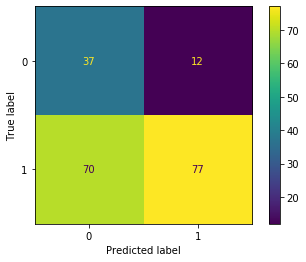

In [86]:
y_pred_lgbm1 = clf_lgbm.predict(X_test[symbol][[f'{x}_{n1}' for x in ti_list]])
print(classification_report(y_pred_lgbm1, y_test[symbol][f'signal_{n2}']))

plot_confusion_matrix(
    clf_lgbm,
    X_test[symbol][[f'{x}_{n1}' for x in ti_list]],
    y_test[symbol][f'signal_{n2}'],
    #normalize='all'
)


In [87]:
calc_returns(y_pred_lgbm1, signals_baseline=1, prices=djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_Baseline
Epoch,,,,
2019-01-30 00:00:00+00:00,NaN,1,NaN,NaN
2019-01-31 00:00:00+00:00,0.023493,1,0.023493,0.023493
2019-02-01 00:00:00+00:00,-0.001996,1,0.021497,0.021497
2019-02-04 00:00:00+00:00,-0.013000,1,0.008497,0.008497
2019-02-05 00:00:00+00:00,0.000675,1,0.009173,0.009173
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,0,-0.014390,0.282838
2019-11-01 00:00:00+00:00,0.011951,0,-0.014390,0.294789
2019-11-04 00:00:00+00:00,-0.001540,0,-0.014390,0.293248


## Single lookback/lookahead with hyperparameter optimization

In [102]:
def returns_score(y_true, y_pred, data):
    return calc_returns(y_pred, signals_baseline = 1, prices = data)['Cum_Returns_Strat'][-1]


In [103]:
from atomm.Models.Tuning import search_space
from atomm.Models.Tuning import BayesianOptimizer
from hyperopt import space_eval

In [104]:
opt = BayesianOptimizer(
    param_space=search_space(LGBMClassifier),
    model=LGBMClassifier,
    X_train=X_train[symbol][[f'{x}_{n1}' for x in ti_list]],
    y_train=y_train[symbol][f'signal_{n2}'],
    X_test=X_test[symbol][[f'{x}_{n1}' for x in ti_list]],
    y_test=y_test[symbol][f'signal_{n2}'],
    valid_data=djia[symbol][:test_size]['Close'],
    valid_metric=returns_score,
    num_eval=50,
)


In [105]:
#opt.set_params(objective=logloss_penalize_fp)
#opt.set_params(metrics=['logloss'])

opt.set_params(random_state=R_STATE)
test_score, clf_best, best_param = opt.optimize()

100%|██████████| 50/50 [00:19<00:00,  2.57trial/s, best loss: -0.24834291140238443]
##### Results #####
Score best parameters:  -0.24834291140238443
Best parameters:  {'colsample_bytree': 0.7781392559894312, 'cv': 'cv', 'learning_rate': 5.796235440081907, 'max_depth': 187, 'min_child_samples': 15, 'min_split_gain': 10, 'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'n_estimators': 665, 'num_leaves': 297, 'random_state': 16818}
Test Score (accuracy):  0.5703324808184144
Parameter combinations evaluated:  50


Recall Score:  0.5977337110481586
              precision    recall  f1-score   support

           0       0.08      0.32      0.12        38
           1       0.89      0.60      0.72       353

    accuracy                           0.57       391
   macro avg       0.48      0.46      0.42       391
weighted avg       0.81      0.57      0.66       391



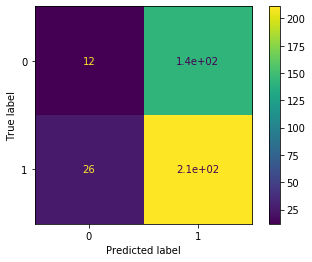

In [106]:
y_pred_bsearch_lgbm = clf_best.predict(X_test[symbol][features])
print('Recall Score: ', recall_score(y_pred_bsearch_lgbm, y_test[symbol][f'signal_{n2}']))
print(classification_report(y_pred_bsearch_lgbm, y_test[symbol][f'signal_{n2}']))
plot_confusion_matrix(
    clf_best,
    X_test[symbol][features], y_test[symbol][f'signal_{n2}'],
)

In [107]:
calc_returns(y_pred_bsearch_lgbm, signals_baseline=1, prices=djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_Baseline
Epoch,,,,
2018-04-20 00:00:00+00:00,NaN,0,NaN,NaN
2018-04-23 00:00:00+00:00,0.006346,1,0.006346,0.006346
2018-04-24 00:00:00+00:00,0.003153,0,0.006346,0.009498
2018-04-25 00:00:00+00:00,0.005714,0,0.006346,0.015213
2018-04-26 00:00:00+00:00,-0.059659,1,-0.053314,-0.044447
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,1,0.004404,0.141290
2019-11-01 00:00:00+00:00,0.011951,0,0.004404,0.153241
2019-11-04 00:00:00+00:00,-0.001540,0,0.004404,0.151701
